In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,img_path,class
0,mdb003.pgm.png,dense
1,mdb004.pgm.png,dense
2,mdb033.pgm.png,dense
3,mdb034.pgm.png,dense
4,mdb035.pgm.png,dense


In [4]:
valid_df.head()

,img_path,class
0,mdb293.pgm.png,fatty
1,mdb297.pgm.png,fatty
2,mdb299.pgm.png,fatty
3,mdb315.pgm.png,dense
4,mdb317.pgm.png,dense


## Image Augmentation:
(no code changes needed)

In [5]:
IMG_SIZE = (224, 224)

In [6]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 6) ## We've only been provided with 6 validation images

Found 20 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.


In [7]:
## Pull a single large batch of random validation data for testing after each epoch
testX, testY = val_gen.next()

## Load in VGG16 with pre-trained ImageNet weights: 
(No code changes needed):

In [8]:
model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 8s 0us/step


In [9]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
for indx, layer in enumerate(model.layers):
    print(indx, layer.name, layer.output_shape)

0 input_1 (None, 224, 224, 3)
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 flatten (None, 25088)
20 fc1 (None, 4096)
21 fc2 (None, 4096)
22 predictions (None, 1000)


In [11]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [12]:
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [13]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1, activation='relu'))

In [25]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [14]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [15]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [16]:
## Run for 10 epochs to see if any learning occurs:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 21s 7s/step - loss: 7.8496 - binary_accuracy: 0.3000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 20s 7s/step - loss: 6.6667 - binary_accuracy: 0.3500 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 20s 7s/step - loss: 6.5951 - binary_accuracy: 0.5000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 20s 7s/step - loss: 10.0094 - binary_accuracy: 0.4000 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 20s 7s/step - loss: 5.1882 - binary_accuracy: 0.4500 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 20s 7s/step - loss: 7.7935 - binary_accuracy: 0.3500 - val_loss: 7.7125 - val_binary_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 20s 7s/step - loss: 4.3865 - binary_a

### Write a function below to plot the output of your training that is stored in the 'history' variable from above: 

In [18]:
history.history

{'val_loss': [7.712474346160889,
  7.712474346160889,
  7.712474346160889,
  7.712474346160889,
  7.712474346160889,
  7.712474346160889,
  7.712474346160889,
  7.712474346160889,
  7.712474346160889,
  7.712474346160889],
 'val_binary_accuracy': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 'loss': [7.882740759849549,
  6.377253842353821,
  6.325348281860352,
  8.702193069458009,
  6.3189522445201876,
  7.81305160522461,
  5.445250260829925,
  6.202053022384644,
  6.204673337936401,
  7.06249098777771],
 'binary_accuracy': [0.3, 0.35, 0.5, 0.4, 0.45, 0.35, 0.45, 0.55, 0.5, 0.45]}

In [28]:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history['loss'])
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0,N), history.history['loss'], label='Training loss')
    plt.plot(np.arange(0,N), history.history['val_loss'], label='Validtion Loss')
    plt.plot(np.arange(0,N), history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(np.arange(0,N), history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss/Accuracy')
    plt.legend(loc='lower left')
    plt.show()

    ### YOUR CODE HERE

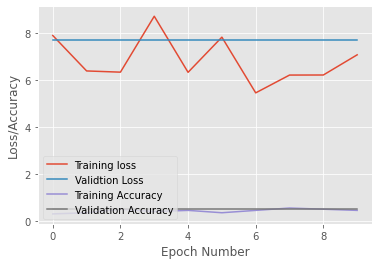

In [29]:
plot_history(history)

## Try a model with less dropout, same learning rate: 

In [31]:
## COPY AND PASTE THE ARCHITECTURE FROM ABOVE, BUT CHANGE THE AMOUNT OF DROPOUT

new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.25))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.20))
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.15))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

In [32]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 21s 7s/step - loss: 0.7937 - binary_accuracy: 0.2500 - val_loss: 0.6966 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 20s 7s/step - loss: 0.7588 - binary_accuracy: 0.5000 - val_loss: 0.7016 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 20s 7s/step - loss: 0.6684 - binary_accuracy: 0.4500 - val_loss: 0.7719 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 20s 7s/step - loss: 0.6363 - binary_accuracy: 0.6000 - val_loss: 0.6740 - val_binary_accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 20s 7s/step - loss: 0.7007 - binary_accuracy: 0.4000 - val_loss: 0.6243 - val_binary_accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 19s 6s/step - loss: 0.5935 - binary_accuracy: 0.6000 - val_loss: 0.6139 - val_binary_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 20s 7s/step - loss: 0.4305 - binary_ac

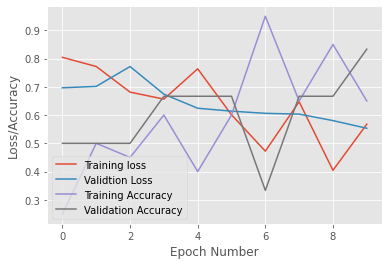

In [34]:
plot_history(history)

## Finally, try a model with the same amount of dropout as you initiall had, but a slower learning rate: 

In [35]:
## COPY AND PASTE THE ARCHITECTURE FROM THE FIRST EXAMPLE

new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.25))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.20))
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.15))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

In [37]:
## CHANGE THE LEARNING RATE DEFINED IN Adam():

optimizer = Adam(lr=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [38]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [39]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 21s 7s/step - loss: 0.8340 - binary_accuracy: 0.5500 - val_loss: 0.7970 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 20s 7s/step - loss: 0.7390 - binary_accuracy: 0.5000 - val_loss: 0.7883 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 20s 7s/step - loss: 0.8056 - binary_accuracy: 0.5500 - val_loss: 0.7803 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 20s 7s/step - loss: 0.8359 - binary_accuracy: 0.5000 - val_loss: 0.7727 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 20s 7s/step - loss: 0.8179 - binary_accuracy: 0.4000 - val_loss: 0.7646 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 20s 7s/step - loss: 0.8281 - binary_accuracy: 0.4000 - val_loss: 0.7576 - val_binary_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 20s 7s/step - loss: 0.6943 - binary_ac

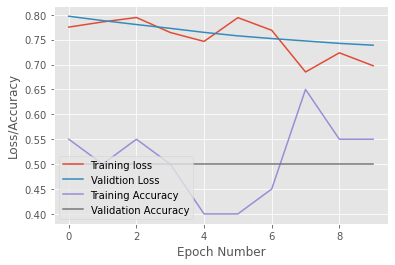

In [40]:
plot_history(history)